In [7]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')

from tmm.get_jacobi_n_adjoint import get_jacobi_free_form
from film import TwoMaterialFilm, FreeFormFilm, BaseFilm
from design import DesignForFilm

from optimizer.adam_n import adam_optimize

import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy

inc_ang = 0.
wls = np.linspace(500, 2000, 500)

#  make target film
# np.random.seed(1)
# d = np.random.random(15)
# d *= 1000. / d.sum()

d = np.array([100, 100] * 5)
target_film = TwoMaterialFilm('2', '1', 'SiO2', d)
target_film.add_spec_param(inc_ang, wls)


In [ ]:
# thickness gd
np.random.seed(42)
init_layers = 100
d = np.random.random(init_layers) + 1.
d = d * 1000 / d.sum() # total gd = 1000 nm
rand_2m_gd_film = TwoMaterialFilm('1', '2', 'SiO2', d)
design = DesignForFilm(target_film, rand_2m_gd_film)

design.adam_gd(4000, record=True, show=True, alpha=0.1)


In [ ]:

# free form gd
np.random.seed(42)
# n = np.random.random(1000) + 1. # in (1, 2)
n = np.random.random(1000) * 3
free_film = FreeFormFilm(n, 1000., 'SiO2')

# free_film.add_spec_param(inc_ang, wls)
# plot_layer_thickness(free_film)

def gd_one_ang(target_film: BaseFilm, film: FreeFormFilm):
    target_film = copy.deepcopy(target_film)
    target_film.remove_all_spec_param()
    target_film.add_spec_param(0., wls)
    losses, films = adam_optimize(
        film, 
        target_film.get_all_spec_list(), 
        500, 
        alpha=0.1, 
        beta1=0.9, 
        beta2=0.999, 
        record=True, 
        show=True, 
        n_min=1, 
        n_max=2, 
        batch_size_wl=100
    )
    return losses, films

def gd_two_angs(target_film: BaseFilm, film: FreeFormFilm):
    target_film = copy.deepcopy(target_film)
    
    target_film.remove_all_spec_param()
    target_film.add_spec_param(45., wls)
    target_film.add_spec_param(0., wls)
    
    losses, films = adam_optimize(
        film, 
        target_film.get_all_spec_list(), 
        500, 
        alpha=0.1, 
        beta1=0.9, 
        beta2=0.999, 
        record=True, 
        show=True, 
        n_min=1, 
        n_max=2, # note that this constraint is extra info
        batch_size_wl=200, 
        
    )
    return losses, films


losses, films = gd_two_angs(target_film, free_film)

working_film_save_dir = './films_double_specs'
with open(working_film_save_dir, 'wb') as  f:
    pickle.dump(films, f)

In [14]:
from analyze_utils.structure import diff_simple_film

with open(working_film_save_dir, 'rb') as f:
    films = pickle.load(f)
    
similarities = []

for film in films:
    similarities.append(diff_simple_film(target_film, film))
    


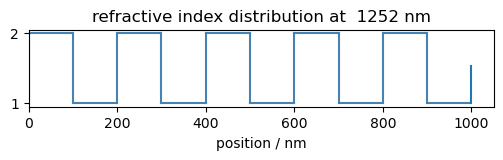

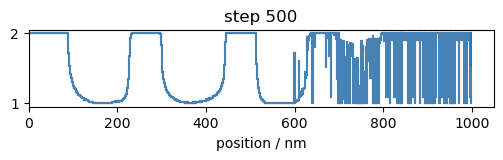

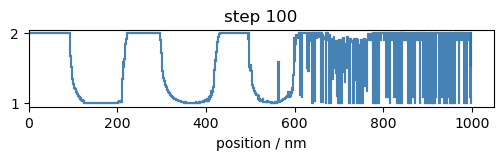

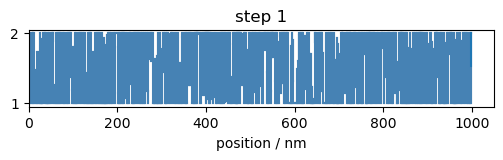

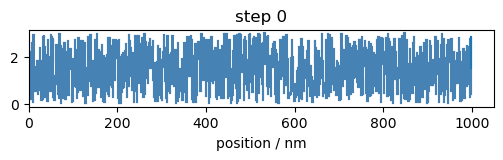

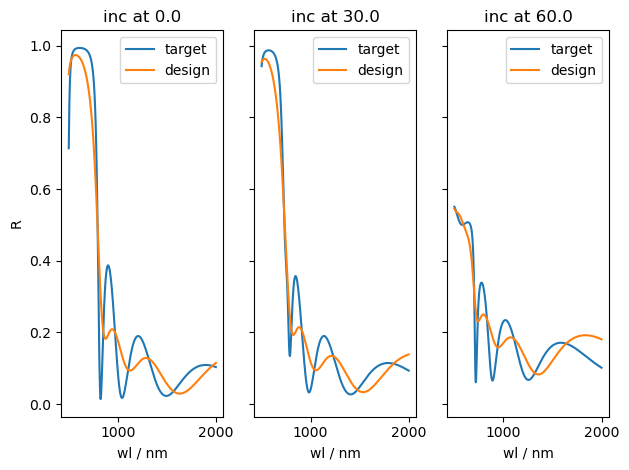

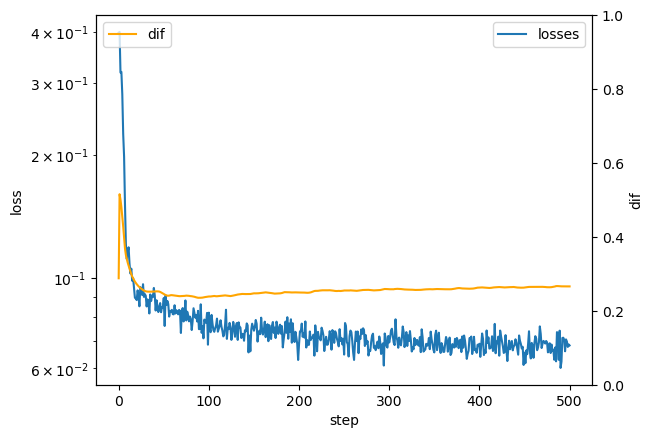

In [15]:

from analyze_utils.structure import plot_layer_thickness

plot_layer_thickness(target_film)
plot_i = list(range(2)) + [100, 500]
for i in plot_i[::-1]:
    f: BaseFilm = copy.deepcopy(films[i])
    d = f.get_d()
    sum = 0
    for j, di in enumerate(d):
        if sum > 1000:
            break
        sum += di
    d = d[:j]

    f.update_d(d)
    ax, _ = plot_layer_thickness(f)
    ax.set_title(f'step {i}')


# plot specs# plot specs
spec_param_ls = [[0., wls], [30., wls], [60., wls]]
fig, axes = plt.subplots(
    1, 
    len(spec_param_ls), 
    sharey=True, 
)
axes = [axes] if isinstance(axes, plt.Axes) else axes # special case: 1 spec
axes[0].set_ylabel('R')
for ax, spec_arg in zip(axes, spec_param_ls):
    ax.plot(
        wls, 
        target_film.get_spec(*spec_arg).get_R(), 
        label='target'
    )
    ax.plot(
        wls, 
        free_film.get_spec(*spec_arg).get_R(), 
        label='design'
    )
    ax.set_title(f'inc at {spec_arg[0]}')
    ax.set_xlabel('wl / nm')
    ax.legend()
fig.tight_layout()


fig, ax = plt.subplots(1, 1)
ax.plot(losses, label='losses')
ax.set_xlabel('step')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.legend(loc='upper right')

ax2 = ax.twinx()
ax2.plot(similarities, label='dif', c='orange')
ax2.set_ylabel('dif')
ax2.set_ylim(0, 1)
ax2.legend(loc='upper left')
